# Required Installs

In [ ]:
!pip install transformers==4.1.1 
!pip install scikit-learn==0.21.3
!pip install node2vec==0.4.1 #0.4.1
!pip install networkx==2.5 # 2.5 , gensim-3.8.3
!pip install ipywidgets
from ipywidgets import IntProgress

     |████████████████████████████████| 1.5 MB 4.0 MB/s 
     |████████████████████████████████| 895 kB 37.2 MB/s 
     |████████████████████████████████| 2.9 MB 38.3 MB/s 
     |████████████████████████████████| 6.7 MB 3.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.21.3 which is incompatible.
  Created wheel for node2vec: filename=node2vec-0.4.1-py3-none-any.whl size=5736 sha256=2acbc3eb19895fcd02d1699f2ff0f4a323a4b8ae4d2375e65142a0c32e520526
  Stored in directory: /root/.cache/pip/wheels/c2/0d/97/1d98c4bdf1e8cccae7442ec3ebd39f44e462f9878c6d0c3211
Successfully built node2vec
     |█████████████████

# Load the Social Context Embedders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import transformers
import tqdm
import networkx as nx
import pickle
import pandas as pd

In [ ]:
def get_social_context_embedder(social_context_embeddings_pickle_file):
    return pickle.load(open(social_context_embeddings_pickle_file, 'rb'))

In [ ]:
def get_social_embeddings(social_context_embedder):
  D = {}
  for key in social_context_embedder.wv.vocab.keys():
    D[key]=social_context_embedder[key]/np.linalg.norm(social_context_embedder[key])
  return D      

In [ ]:
def get_control_code_embeddings(label_embedder):
  control_code_embedder={}
  for key in label_embedder.wv.vocab:
    control_code_embedder[key]=str(np.random.randint(0, 1000000))
  return control_code_embedder

# Dataset Readers 

In [ ]:
from transformers import LineByLineTextDataset
from torch.utils.data.dataset import Dataset, IterableDataset
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.utils import logging
from transformers import Trainer, TrainingArguments
import numpy as np
logger = logging.get_logger(__name__)

In [ ]:
from dataclasses import dataclass
from transformers import DataCollatorForLanguageModeling

In [ ]:
class SocialLineByLineTextDataset(IterableDataset):
    # Code based on https://github.com/huggingface/transformers/blob/master/src/transformers/data/datasets/language_modeling.py
    def __init__(self, file_path: str, total_lines, unit_test=False, batch_size=16):
        import os
        print(file_path)
        assert os.path.isfile(file_path)
        self.file_path = file_path
        self.unit_test = unit_test
        self.batch_size = batch_size
        if self.unit_test:
          print("Unit test")
          self.num_lines = 1000
        else:
          self.num_lines = total_lines
        logger.info("Creating features from dataset file at %s", file_path)
      
    def __iter__(self):
        num_lines = 0
        with open(self.file_path, encoding="utf-8") as f:
          for l in f:
            if (len(l) > 0) and (not l.isspace()):
              social_context, text = l.split('\t')
              num_lines+=1
              if self.unit_test and (num_lines>=1000):
                break
              yield social_context, text.strip()
              
    def  __len__(self):
        return int(self.num_lines)

In [ ]:
class ControlCodeLineByLineTextDataset(IterableDataset):
    # Code based on https://github.com/huggingface/transformers/blob/master/src/transformers/data/datasets/language_modeling.py
    def __init__(self, file_path: str, total_lines, control_code_embedder, unit_test=False, batch_size=16):
        import os
        print(file_path)
        assert os.path.isfile(file_path)
        self.file_path = file_path
        self.unit_test = unit_test
        self.batch_size = batch_size
        self.control_code_embedder = control_code_embedder
        if self.unit_test:
          print("unit test")
          self.num_lines = 1000
        else:
          self.num_lines = total_lines
        logger.info("Creating features from dataset file at %s", file_path)
      
    def __iter__(self):
        num_lines = 0
        with open(self.file_path, encoding="utf-8") as f:
          for l in f:
            if (len(l) > 0) and (not l.isspace()):
              social_context, text = l.split('\t')
              num_lines+=1
              if self.unit_test and (num_lines>=1000):
                break
              yield '{} {}'.format(text.strip(), self.control_code_embedder[social_context])
              
    def  __len__(self):
        return int(self.num_lines)

In [ ]:
@dataclass
class SocialDataCollatorForLanguageModeling(DataCollatorForLanguageModeling):
    """
     Based on https://huggingface.co/transformers/_modules/transformers/data/data_collator.html#DataCollatorForLanguageModeling
    """
    social_context_embeddings: dict = None
    def _collate_batch(self, examples, tokenizer):
        social_contexts = list(zip(*examples))[0]
        texts = list(list(zip(*examples))[1])
        batch_encoding = tokenizer.batch_encode_plus(texts, add_special_tokens=True, max_length=32, truncation=True)
        new_examples = []
        for i in np.arange(0, len(social_contexts)):
          text_input = torch.tensor(batch_encoding['input_ids'][i], dtype=torch.long)
          new_examples.append((social_contexts[i], text_input))
        return new_examples
    
    def __call__(
        self, examples
    ):
        batch = {}
        examples = self._collate_batch(examples, self.tokenizer)
        social_contexts = list(zip(*examples))[0]
        text_view = list(zip(*examples))[1]
        social_contexts_emb = torch.Tensor(np.array([self.social_context_embeddings[context] for context in social_contexts])).float()
        data = DataCollatorForLanguageModeling.__call__(self, examples=text_view)
        data['social_contexts'] = social_contexts_emb
        batch["inputs"] = data
        return batch

In [ ]:
@dataclass
class ControlCodeDataCollatorForLanguageModeling(DataCollatorForLanguageModeling):
    """
    Based on https://huggingface.co/transformers/_modules/transformers/data/data_collator.html#DataCollatorForLanguageModeling
    """
    def _collate_batch(self, examples, tokenizer):
        texts = examples
        batch_encoding = tokenizer.batch_encode_plus(texts, add_special_tokens=True, max_length=32, truncation=True)
        new_examples = []
        for i in np.arange(0, len(examples)):
          text_input = torch.tensor(batch_encoding['input_ids'][i], dtype=torch.long)
          new_examples.append(text_input)
        return new_examples
    
    def __call__(
        self, examples
    ):
        batch = {}
        examples = self._collate_batch(examples, self.tokenizer)
        data = DataCollatorForLanguageModeling.__call__(self, examples=examples)
        batch["inputs"] = data
        return batch

# Models

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
pt_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
class NaiveLM(torch.nn.Module):
  #Ignores social context, the baseline
  def __init__(self,  pt_model, social_dim_size = 768):
    super(NaiveLM, self).__init__()
    self.pt_model = pt_model 
    
  def forward(self, inputs, output_hidden_states=None): #inputs is dictionary containing {'input_ids': , 'labels':, 'social_contexts':} where 'labels' is optional
    MASK_TOKEN=-100
    pt_input_embs_table=pt_model.get_input_embeddings().to(device)
    input_embs = pt_input_embs_table(inputs['input_ids'].to(device))
    if ('labels' in inputs):
      pt_output=self.pt_model(inputs_embeds=input_embs, labels=inputs['labels'].to(device), output_hidden_states=output_hidden_states)
    else:
      pt_output=self.pt_model(inputs_embeds=input_embs, output_hidden_states=output_hidden_states)
    return pt_output

In [ ]:
class SocialLM(torch.nn.Module):
  def __init__(self, pt_model, social_dim_size = 768):
    super(SocialLM, self).__init__()
    self.pt_model = pt_model
    self.social_dim_size = social_dim_size

  def forward(self, inputs, output_hidden_states=None): #inputs is dictionary containing {'input_ids': , 'labels':, 'social_contexts':} where 'labels' is optional
    MASK_TOKEN=-100
    pt_input_embs_table=pt_model.get_input_embeddings().to(device)
    social_contexts = inputs['social_contexts'].to(device)
    assert(social_contexts.shape[1]==self.pt_model.config.hidden_size)
    social_contexts_reshape = social_contexts.unsqueeze(dim=1)
    input_embs = pt_input_embs_table(inputs['input_ids'].to(device))
    input_embs_cat = torch.cat([input_embs, social_contexts_reshape], dim=1)
    if ('labels' in inputs):
      label_context = torch.tensor(np.ones(input_embs.shape[0])*MASK_TOKEN, dtype=int).unsqueeze(dim=1)
      label_cat =  torch.cat([inputs['labels'],label_context], dim=1)
      pt_output=self.pt_model(inputs_embeds=input_embs_cat.to(device), labels=label_cat.to(device), output_hidden_states=output_hidden_states)
    else:
      pt_output=self.pt_model(inputs_embeds=input_embs_cat.to(device), output_hidden_states=output_hidden_states)
    return pt_output

# Training

In [ ]:
from transformers import TrainerCallback
class PrinterCallback(TrainerCallback):
    def on_log(self, args, state, control, model, logs=None, **kwargs):
        pass

In [ ]:
def train_model(model, data_collator, dataset, max_epochs=2, max_steps=-1):
  training_args = TrainingArguments(
      output_dir="./working_output",
      overwrite_output_dir=True,
      per_gpu_train_batch_size=BATCH_SIZE,
      num_train_epochs = max_epochs,
      save_steps=10_000,
      save_total_limit=2,
      prediction_loss_only = True,
      warmup_steps=500,                # number of warmup steps for learning rate scheduler
      weight_decay=0.01,               # strength of weight decay
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      data_collator=data_collator,
      train_dataset=dataset,
  )
  trainer.train()

In [ ]:
print(torch.cuda.is_available())
print(torch.__version__)
print(transformers.__version__)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

True
1.10.0+cu111
4.1.1


In [ ]:
dataset_name = "/content/drive/My Drive/data/toy_presidents_corpus_hard.csv"
output_file="/content/drive/data/My Drive/toy_presidents_corpus_hard.dict"
output_pickle="/content/drive/data/My Drive/toy_presidents_corpus_hard.pkl"
social_context_embeddings_pickle_file = "/content/drive/My Drive/data/toy_president_time.pkl"
BATCH_SIZE=64

In [ ]:
social_context_embedder = get_social_context_embedder(social_context_embeddings_pickle_file)
social_context_embeddings = get_social_embeddings(social_context_embedder)
SOCIAL_DIM = len(list(social_context_embeddings.values())[0])
assert(SOCIAL_DIM==768)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [ ]:
control_code_embedder = get_control_code_embeddings(social_context_embedder)

In [ ]:
dataset=SocialLineByLineTextDataset(file_path = dataset_name, total_lines = 40000, unit_test=False, batch_size=BATCH_SIZE)
control_code_dataset=ControlCodeLineByLineTextDataset(file_path = dataset_name, total_lines = 40000, control_code_embedder = control_code_embedder, unit_test=False, batch_size=BATCH_SIZE)

/content/drive/My Drive/data/toy_presidents_corpus_hard.csv
/content/drive/My Drive/data/toy_presidents_corpus_hard.csv


In [ ]:
data_collator = SocialDataCollatorForLanguageModeling(tokenizer=pt_tokenizer, mlm=True, mlm_probability=0.15, social_context_embeddings=social_context_embeddings)
control_code_data_collator = ControlCodeDataCollatorForLanguageModeling(tokenizer=pt_tokenizer, mlm=True, mlm_probability=0.15)

In [ ]:
pt_model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
naive_model = NaiveLM(pt_model = pt_model, social_dim_size=SOCIAL_DIM)
naive_model = naive_model.to(device)
naive_model.train()
train_model(naive_model, data_collator, dataset, max_epochs=2)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will b

Step,Training Loss
500,1.355348


Step,Training Loss
500,1.355348
1000,0.854396


In [ ]:
pt_model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
naive_model_control_code = NaiveLM(pt_model = pt_model, social_dim_size=SOCIAL_DIM)
naive_model_control_code = naive_model_control_code.to(device)
naive_model_control_code.train()
train_model(naive_model_control_code, data_collator=control_code_data_collator, dataset=control_code_dataset, max_epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will b

Step,Training Loss
500,1.091222
1000,0.080599


In [ ]:
pt_model = AutoModelForMaskedLM.from_pretrained("bert-base-uncased")
social_model = SocialLM(pt_model = pt_model, social_dim_size=SOCIAL_DIM)
social_model = social_model.to(device)
social_model.train()
train_model(social_model, data_collator, dataset, max_epochs=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will be removed in a future version. Using `--per_device_train_batch_size` is preferred.
Using deprecated `--per_gpu_train_batch_size` argument which will b

Step,Training Loss
500,0.812347
1000,0.096834


# Evaluation 

In [ ]:
time_presidents_map=pickle.load(open('/content/drive/My Drive/data/time_presidents_map.pkl', 'rb'))

In [ ]:
time_presidents_map

{(1900, 1904): ('Anthony', 'Dan'),
 (1905, 1909): ('Bob', 'Kennedy'),
 (1910, 1914): ('Charlie', 'John'),
 (1915, 1919): ('Dan', 'Robert'),
 (1920, 1924): ('Dick', 'George'),
 (1925, 1929): ('Frank', 'Dick'),
 (1930, 1934): ('George', 'Frank'),
 (1935, 1939): ('Henry', 'Henry'),
 (1940, 1944): ('Jack', 'Jill'),
 (1945, 1949): ('Kennedy', 'Jack'),
 (1950, 1954): ('Jill', 'Anthony'),
 (1955, 1959): ('Steve', 'Andrew'),
 (1960, 1964): ('Andrew', 'Bush'),
 (1965, 1969): ('Robert', 'Kate'),
 (1970, 1974): ('John', 'Clinton'),
 (1975, 1979): ('Kate', 'Steve'),
 (1980, 1984): ('Clinton', 'Obama'),
 (1985, 1989): ('Bush', 'Trump'),
 (1990, 1994): ('Obama', 'Charlie'),
 (1995, 1999): ('Trump', 'Bob')}

In [ ]:
def top_candidates(text, social_context_emb, tokenizer, model, mask_pos,  topk=2, verbose = False):
  # mask_pos 0 for President, 1 for minister
  import torch.nn.functional as F
  encoded_input = tokenizer(text, return_tensors='pt')
  if verbose:
    print(encoded_input)
  encoded_input['social_contexts']=torch.Tensor(social_context_emb).reshape(1,-1)
  model.eval()
  output = model(encoded_input)
  topk_outputs = torch.topk(output['logits'][0][mask_pos], k=topk)
  topk_indices = topk_outputs.indices
  if verbose:
    print(topk_outputs, tokenizer.decode(topk_indices))
  return topk_outputs,  tokenizer.decode(topk_indices), F.softmax(topk_outputs.values).cpu().data.numpy() 

In [ ]:
def mean_confidence_interval(data, confidence=0.95):
    import scipy
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [ ]:
def evaluate_model(model, sc_embeddings, is_control_code=False, mode=2):
  def get_rank_for_text(text, year, correct_answer_pos):
      correct_answer = time_presidents_map[time_range][correct_answer_pos].lower()
      # mask_pos is 7 because it is guaranteed in this evaluation that the mask occurrs at index 7. This should ideally be obtained by looking for the index containing 103 in the tokenized text.
      ret=top_candidates(text, sc_embeddings[str(year)], pt_tokenizer, model, mask_pos = 7, topk=pt_tokenizer.vocab_size)
      correct_token_id = pt_tokenizer.convert_tokens_to_ids(correct_answer)
      rank = np.argwhere(ret[0].indices.cpu()==correct_token_id).cpu().numpy()[0][0]
      return rank

  ranks = []
  for time_range in time_presidents_map:
    start_year = time_range[0]
    end_year = time_range[1]
    if mode == 0: ## SEEN ONLY
      syear = start_year
      eyear = start_year + 1
    elif mode == 1: ## UNSEEN ONLY
      syear  = start_year + 1
      eyear = end_year + 1 
    elif mode == 2: #ALL
      syear = start_year
      eyear = end_year + 1
    else:
      assert(False)
    for year in np.arange(syear, eyear):
      if is_control_code:
        stryear = control_code_embedder[str(year)]
        text_1 = "Our country's minister is [MASK] {}".format(stryear)
        text_2 = "Our country's president is [MASK] {}".format(stryear)
        text_3 = "The minister of our country is [MASK] {}".format(stryear)
        text_4 = "The president of our country is [MASK] {}".format(stryear)
      else:
        text_1 = "Our country's minister is [MASK]"
        text_2 = "Our country's president is [MASK]"
        text_3 = "The minister of our country is [MASK]"
        text_4 = "The president of our country is [MASK]"
      rank_1 = get_rank_for_text(text_1, year, 1) # Minister
      ranks.append(rank_1)
      rank_2 = get_rank_for_text(text_2, year, 0) # President
      ranks.append(rank_2)
      rank_3 = get_rank_for_text(text_3, year, 1) # Minister
      ranks.append(rank_3)
      rank_4 = get_rank_for_text(text_4, year, 0) # President
      ranks.append(rank_4)
  reciprocal_ranks = 1.0/(np.array(ranks)+1)
  return  mean_confidence_interval(reciprocal_ranks), np.std(reciprocal_ranks), mean_confidence_interval(ranks), np.std(ranks)

In [ ]:
orecs = []
mode_map = {'seen':0, 'unseen':1, 'overall':2}
model_map = {'BERT': naive_model, 'LM-CTRL': naive_model_control_code, 'LM-SOC':social_model}
for mode_key in mode_map:
  for model_key in model_map:
    if model_key!='LM-CTRL':
      result = evaluate_model(model_map[model_key], social_context_embeddings, mode=mode_map[mode_key])
    else:
      result = evaluate_model(model_map[model_key], social_context_embeddings, is_control_code=True, mode=mode_map[mode_key])
    mrr, mrrl, mrrh = result[0]
    mrr_std = result[1]
    mrank, mrankl, mrankh = result[2]
    mrank_std = result[3]
    orecs.append((model_key, mode_key, mrr, mrrl, mrrh, mrr_std, mrank, mrankl, mrankh, mrank_std))

odf = pd.DataFrame().from_records(orecs, columns=['model', 'mode','mrr', 'mrrl', 'mrrh', 'mrr_std','mrank', 'mrankl','mrankh', 'mrank_std'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
odf

,model,mode,mrr,mrrl,mrrh,mrr_std,mrank,mrankl,mrankh,mrank_std
0,BERT,seen,0.179887,0.131106,0.228668,0.217828,9.500000,8.208681,10.791319,5.766281
1,LM-CTRL,seen,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,LM-SOC,seen,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,BERT,unseen,0.179887,0.155892,0.203882,0.217828,9.500000,8.864816,10.135184,5.766281
4,LM-CTRL,unseen,0.160265,0.140896,0.179633,0.175829,20.696875,12.028238,29.365512,78.695012
5,LM-SOC,unseen,0.721002,0.686812,0.755192,0.310382,1.246875,0.891984,1.601766,3.221751
6,BERT,overall,0.179887,0.158449,0.201325,0.217828,9.500000,8.932486,10.067514,5.766281
7,LM-CTRL,overall,0.328212,0.291709,0.364715,0.370888,16.557500,9.582301,23.532699,70.872150
8,LM-SOC,overall,0.776801,0.747354,0.806249,0.299206,0.997500,0.709676,1.285324,2.924465


In [ ]:
odf.to_csv('/content/drive/My Drive/data/task1_eval.csv')

In [ ]:
odf=odf.sort_values(by='model')

In [ ]:
odf=pd.read_csv('/content/drive/My Drive/data/task1_eval.csv', index_col=0)

In [ ]:
model_map={'BERT':'BERT', 'LM-CTRL':'LMCTRL','LM-SOC':'LMSOC'}
odf["model_name"]=odf["model"].map(model_map)

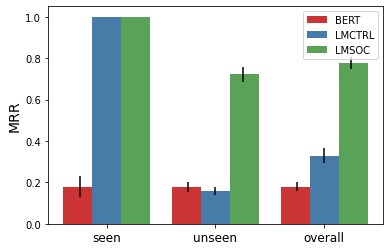

In [ ]:
import seaborn as sns
import pylab as pl
import numpy as np
ax  = sns.barplot(x='mode', y='mrr', hue='model_name', data=odf[["mode","mrr","model_name"]], palette='Set1', order=['seen', 'unseen', 'overall'])
# Bottom error, then top
yerr = [odf['mrr']-odf['mrrl'], odf['mrrh'] - odf['mrr']]
conc2=[0,0,0,1,1,1,2,2,2]
width = .25
add = [-1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width,]
x = np.array(conc2)+np.array(add)
pl.errorbar(x=x,
            y=odf["mrr"],
            yerr=yerr, fmt='none', c= 'k')
pl.legend(loc='best')
ax.set_ylabel('MRR', fontsize=14)
ax.set_xlabel('', fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
pl.savefig('/content/drive/My Drive/data/task1_fig_better.pdf', bbox_inches='tight')

# Quick sanity and qualitative check

In [ ]:
text = "Our country's president is [MASK]"
ret=top_candidates(text, social_context_embeddings['1901'], pt_tokenizer, social_model, mask_pos = 7, topk=pt_tokenizer.vocab_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
print(ret)

(torch.return_types.topk(
values=tensor([ 22.4715,   7.7674,   6.6736,  ..., -19.6469, -20.8020, -21.6099],
       device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([ 4938, 10454,  4080,  ..., 14820, 26212, 21663], device='cuda:0')), 'anthony jill andrew kate dick pier thomas tim tom tony lauren philip paul colin steve pierre frank george robert peter jack dan lawrence emily antony dr town sal bob pete jim february john austin stephen joseph michael timothy. the co cal dar james clinton adam derek alexander william samann bell henry patrick francis relations lewis edwarddley albert oliver martin gavin jeff richard dennis angela chris greg moods may far and guy larry matthew tacoma bon cap todd david charlie mel mr laurence joe nicholas jeremy darrell - ye kennedy helen april is wheeler inches nell harvey, mary la position l tr tam mic brandon edith pal max phillip charles simonolt fir sociales kitty texas gabrielle present bill at luke ann carmel hiltonook minister ian on paz s

In [ ]:
print("Top candidates are", ret[1])

Top candidates are anthony jill andrew kate dick pier thomas tim tom tony lauren philip paul colin steve pierre frank george robert peter jack dan lawrence emily antony dr town sal bob pete jim february john austin stephen joseph michael timothy. the co cal dar james clinton adam derek alexander william samann bell henry patrick francis relations lewis edwarddley albert oliver martin gavin jeff richard dennis angela chris greg moods may far and guy larry matthew tacoma bon cap todd david charlie mel mr laurence joe nicholas jeremy darrell - ye kennedy helen april is wheeler inches nell harvey, mary la position l tr tam mic brandon edith pal max phillip charles simonolt fir sociales kitty texas gabrielle present bill at luke ann carmel hiltonook minister ian on paz susan october con "la luther critics eileen behind maureen st collins house edwin christopher nick mandy billy pat doll russell adams... cat vincent its alone preston? alec michel toward coleman victoria : elena hisitis heath

In [ ]:
print("Top candidates's probability is", ret[2][0])

Top candidates's probability is 0.9999989


In [ ]:
print("Correct president should be", time_presidents_map[(1900, 1904)][0].lower())

Correct president should be anthony


Indeed, we note that LM soc predicts "Anthony" as the most likely token as expected.